# Developing an AI application

Going forward, AI algorithms will be incorporated into more and more everyday applications. For example, you might want to include an image classifier in a smart phone app. To do this, you'd use a deep learning model trained on hundreds of thousands of images as part of the overall application architecture. A large part of software development in the future will be using these types of models as common parts of applications. 

In this project, you'll train an image classifier to recognize different species of flowers. You can imagine using something like this in a phone app that tells you the name of the flower your camera is looking at. In practice you'd train this classifier, then export it for use in your application. We'll be using [this dataset](http://www.robots.ox.ac.uk/~vgg/data/flowers/102/index.html) of 102 flower categories, you can see a few examples below. 

<img src='assets/Flowers.png' width=500px>

The project is broken down into multiple steps:

* Load and preprocess the image dataset
* Train the image classifier on your dataset
* Use the trained classifier to predict image content

We'll lead you through each part which you'll implement in Python.

When you've completed this project, you'll have an application that can be trained on any set of labeled images. Here your network will be learning about flowers and end up as a command line application. But, what you do with your new skills depends on your imagination and effort in building a dataset. For example, imagine an app where you take a picture of a car, it tells you what the make and model is, then looks up information about it. Go build your own dataset and make something new.

First up is importing the packages you'll need. It's good practice to keep all the imports at the beginning of your code. As you work through this notebook and find you need to import a package, make sure to add the import up here.

In [2]:
# Imports here
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

import matplotlib.pyplot as plt

import torch
import numpy as np
from torch import nn
from torch import optim
import torch.nn.functional as F
from torchvision import datasets, transforms, models
from collections import OrderedDict
import time
from PIL import Image

# Inference for classification

Now you'll write a function to use a trained network for inference. That is, you'll pass an image into the network and predict the class of the flower in the image. Write a function called `predict` that takes an image and a model, then returns the top $K$ most likely classes along with the probabilities. It should look like 

```python
probs, classes = predict(image_path, model)
print(probs)
print(classes)
> [ 0.01558163  0.01541934  0.01452626  0.01443549  0.01407339]
> ['70', '3', '45', '62', '55']
```

First you'll need to handle processing the input image such that it can be used in your network. 

## Image Preprocessing

You'll want to use `PIL` to load the image ([documentation](https://pillow.readthedocs.io/en/latest/reference/Image.html)). It's best to write a function that preprocesses the image so it can be used as input for the model. This function should process the images in the same manner used for training. 

First, resize the images where the shortest side is 256 pixels, keeping the aspect ratio. This can be done with the [`thumbnail`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) or [`resize`](http://pillow.readthedocs.io/en/3.1.x/reference/Image.html#PIL.Image.Image.thumbnail) methods. Then you'll need to crop out the center 224x224 portion of the image.

Color channels of images are typically encoded as integers 0-255, but the model expected floats 0-1. You'll need to convert the values. It's easiest with a Numpy array, which you can get from a PIL image like so `np_image = np.array(pil_image)`.

As before, the network expects the images to be normalized in a specific way. For the means, it's `[0.485, 0.456, 0.406]` and for the standard deviations `[0.229, 0.224, 0.225]`. You'll want to subtract the means from each color channel, then divide by the standard deviation. 

And finally, PyTorch expects the color channel to be the first dimension but it's the third dimension in the PIL image and Numpy array. You can reorder dimensions using [`ndarray.transpose`](https://docs.scipy.org/doc/numpy-1.13.0/reference/generated/numpy.ndarray.transpose.html). The color channel needs to be first and retain the order of the other two dimensions.

In [17]:
def process_image(image):
    ''' Scales, crops, and normalizes a PIL image for a PyTorch model,
        returns an Numpy array
    '''
    
    # TODO: Process a PIL image for use in a PyTorch model
   
    #Resize the image to 256x256 pixels
    size = (256,256)
    image_resized = image.resize((size))
    #crop the image to 224x224 pixels (with centering)
    width, height = image_resized.size
    new_width = 224
    new_height =224
    left = (width - new_width)/2
    top = (height - new_height)/2
    right = (width + new_width)/2
    bottom = (height + new_height)/2                             
    image_croped = image_resized.crop((left, top, right, bottom))
    #convert the image to a numpy array
    np_image = np.array(image_croped)
    #transform the image to a tensor normalize the tensor 
    normalize = transforms.Normalize(mean = [0.485, 0.456, 0.406],
                                     std = [0.229, 0.224, 0.225])
    transform = transforms.Compose([transforms.ToTensor(), normalize])
    torch_image1_norm = transform(np_image)
    #reorder the dimensions, because the color channel needs to be first
    #transpose the tensor
    #1. convert the torch tensor to a numpy array
    #2. transpose the numpy array
    #3. reconvert the numpy array to a torch tensor
    #np_array  = torch_image1_norm.numpy()
    #np_array_transposed = np.transpose(np_array, (1, 2, 0))
    #torch_image1_transposed = torch.from_numpy(np_array_transposed)
    #return torch_image
    #return torch_image1_transposed
    return torch_image1_norm

To check your work, the function below converts a PyTorch tensor and displays it in the notebook. If your `process_image` function works, running the output through this function should return the original image (except for the cropped out portions).

In [18]:
def imshow(image, ax=None, title=None):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    
    # PyTorch tensors assume the color channel is the first dimension
    # but matplotlib assumes is the third dimension
    image = image.transpose((1, 2, 0))
    
    # Undo preprocessing
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean
    
    # Image needs to be clipped between 0 and 1 or it looks like noise when displayed
    image = np.clip(image, 0, 1)
    
    ax.imshow(image)
    
    return ax

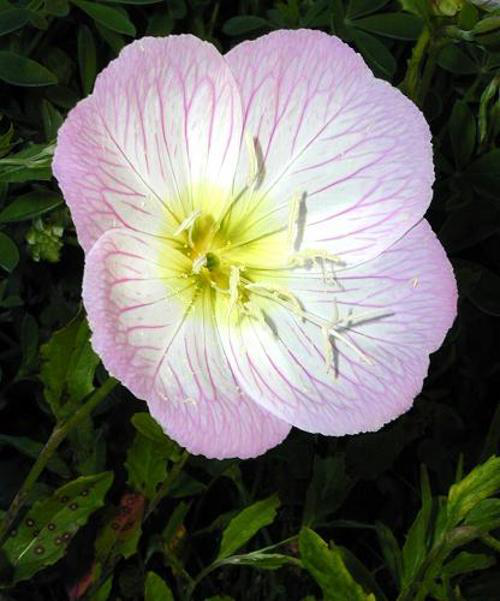

In [19]:
#Test the process_image() function-->part1 load and show the image
filepath1 = 'flowers/test/1/image_06743.jpg'
image1 = Image.open(filepath1)
image1

In [20]:
#Test the process_image() function part2-->preprocess the image with the process_image() function
# and then show the size and values of the returned tensor
returned_tensor = process_image(image1)
print('tensor size: ', returned_tensor.size())
returned_tensor

tensor size:  torch.Size([3, 224, 224])


tensor([[[-2.0152, -1.8953, -1.7240,  ..., -1.5528, -1.1247, -1.0733],
         [-1.8268, -1.7583, -1.7583,  ..., -1.9124, -2.0152, -1.8782],
         [-1.6898, -1.7240, -1.8439,  ..., -1.8782, -1.7754, -1.6384],
         ...,
         [-1.3130, -1.3302, -1.3815,  ..., -1.4843, -1.5014, -1.5357],
         [-1.3815, -1.4500, -1.3644,  ..., -1.6213, -1.6213, -1.6042],
         [-1.5699, -1.6213, -1.7240,  ..., -1.6384, -1.6213, -1.6384]],

        [[-1.8081, -1.6856, -1.5455,  ..., -1.1954, -0.6702, -0.6176],
         [-1.6155, -1.5455, -1.5805,  ..., -1.7031, -1.6856, -1.5455],
         [-1.4755, -1.5105, -1.6681,  ..., -1.7206, -1.5105, -1.3354],
         ...,
         [-0.9328, -0.9153, -0.9153,  ..., -0.9678, -0.9503, -1.0203],
         [-0.9678, -0.9853, -0.8627,  ..., -1.0728, -1.0553, -1.0553],
         [-1.1253, -1.1954, -1.3004,  ..., -1.1604, -1.1779, -1.1954]],

        [[-1.6999, -1.5779, -1.4210,  ..., -1.3687, -0.9156, -0.8284],
         [-1.5256, -1.4559, -1.4733,  ..., -1

TypeError: transpose(): argument 'dim0' (position 1) must be int, not tuple

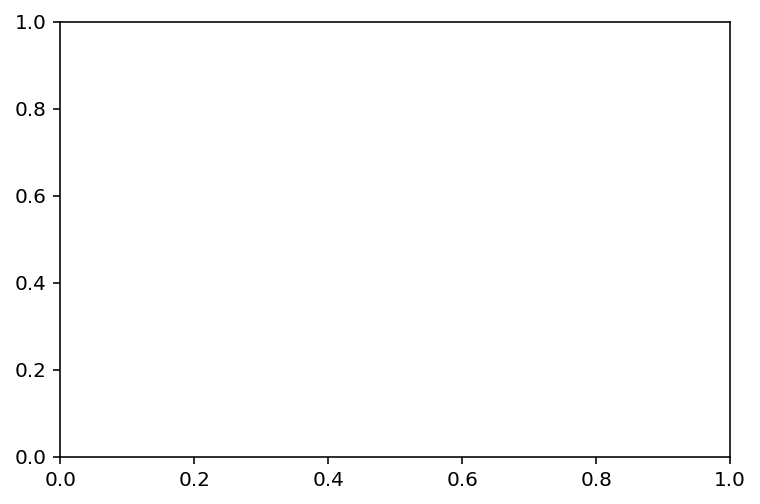

In [22]:
#Test the process_image() function part3--> run the tensor with imshow() function and show the image again.
ax = imshow(returned_tensor, ax=None, title=None)
ax

In [14]:
#for self test

filepath1 = 'flowers/test/1/image_06743.jpg'
image1 = Image.open(filepath1)
filepath2 = 'flowers/test/1/image_06752.jpg'
image2 = Image.open(filepath2)
filepath3 = 'flowers/test/1/image_06754.jpg'
image3 = Image.open(filepath3)
filepath4 = 'flowers/test/1/image_06760.jpg'
image4 = Image.open(filepath4)
filepath5 = 'flowers/test/1/image_06764.jpg'
image5 = Image.open(filepath5)



image1 format:  JPEG
image1 size:  (500, 601)
image1 mode:  RGB
image2 format:  JPEG
image2 size:  (692, 500)
image2 mode:  RGB
image3 format:  JPEG
image3 size:  (593, 500)
image3_mode:  RGB
image4 format:  JPEG
image4 size:  (840, 500)
image4 mode:  RGB
image5 format:  JPEG
image5 size:  (667, 500)
image5 mode:  RGB
